## Importing needed required libraries, also using Tensorflow which is not included in conda you will need to pip install it prior to running this notebook
### creating df from github repositiory we have created

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error



ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://raw.githubusercontent.com/LyJacky/stocks/4802f4e0f139ee0568afbad309086d90c78a53b7/all_stocks_5yr.csv")


2022-12-05 09:09:59.596870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### In the dataset each stock has 1259 days of stocks which is why we have picked the first 1259 days.



In [3]:
df1 = df.reset_index()['close']
# only for AAL stock
df1 = df1[0:1259]
df1

0       14.75
1       14.46
2       14.27
3       14.66
4       13.99
        ...  
1254    53.88
1255    52.10
1256    49.76
1257    51.18
1258    51.40
Name: close, Length: 1259, dtype: float64

### Plotting the graph of the closing price vs the date(implied)
### Only using the closing price to predict the price, the x axis represents the days

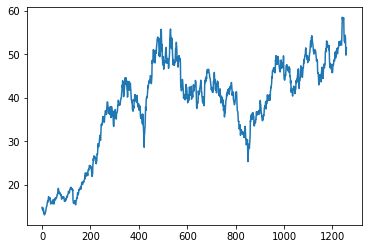

In [4]:
plt.plot(df1)

## Normalizing the data using MinMaxScaler to values between 0 and 1

In [5]:
# scales the close values between the values 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.03806381],
       [0.03168317],
       [0.02750275],
       ...,
       [0.80836084],
       [0.83960396],
       [0.84444444]])

## Making training and testing data, since we are dealing with stocks we must split them in a sequential way having the training data have data all before one of the testing data. 
### The data will basically be partitioned into the first .65% being training and the other testing 

In [6]:
# training size is the number of data we are going to use for the traning data
training_size=int(len(df1)*0.65)
# test_size is just the complement of training size.
test_size=len(df1)-training_size
# makes 2 new lists train_data and test_data which are both subsets of the df1
# train_data is going to be df1 from 0 to training size, and tet_data will be from training size to the rest of the data
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

## Since we are going to deal with LSTM's the input must be a sequence. Hence all of our X_train and X_test will be a sequence of the price 100 days prior the current day
### The y train and test will jus tbe the stock of the day of

In [7]:
time_step = 100
X_train, y_train = [], []
for i in range(len(train_data)-time_step-1):
    a = train_data[i:(i+time_step), 0]   
    X_train.append(a)
    y_train.append(train_data[i + time_step, 0])


X_test, ytest = [], []
for i in range(len(test_data)-time_step-1):
    a = test_data[i:(i+time_step), 0]   
    X_test.append(a)
    ytest.append(test_data[i + time_step, 0])

### Converting all of the lists intp np arrays in order to reshape the list in a later stage so that the keras libary has the proper inputs for the necessary functions

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
ytest = np.array(ytest)

In [9]:
X_train

array([[0.03806381, 0.03168317, 0.02750275, ..., 0.07480748, 0.08316832,
        0.0750275 ],
       [0.03168317, 0.02750275, 0.03608361, ..., 0.08316832, 0.0750275 ,
        0.08206821],
       [0.02750275, 0.03608361, 0.02134213, ..., 0.0750275 , 0.08206821,
        0.0840484 ],
       ...,
       [0.67392739, 0.68360836, 0.63960396, ..., 0.47678768, 0.47106711,
        0.47436744],
       [0.68360836, 0.63960396, 0.63256326, ..., 0.47106711, 0.47436744,
        0.44422442],
       [0.63960396, 0.63256326, 0.65071507, ..., 0.47436744, 0.44422442,
        0.43531353]])

## Reshaping the list thanks to np arrays where the 3rd dim is the number of features

In [10]:
# last one says one feature, reshapes features so its a 3 dim and the last dim is the number of features
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Importing proper libraries for LSTM and neural networks

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

### Creating LSTM Model with one input layer, another 3 layers of 50 LSTM nodes (whenever we have an LSTM layer we must do return sequence since LSTM require sequences), hence for the last layer we must put return sequence false which is the default
### Training the LSTM Model with 100 epochs which represents the 100 days

In [12]:
# Building the LSTM model using keras
# input node is a sequence since LSTM accept sequences
model=Sequential()
# goes to a layer of 50 LSTM nodes which return a sequence
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# goes to another layer of 50 LSTM nodes which return a sequence
model.add(LSTM(50,return_sequences=True))
# goes to the last layer of 50 LSTM node, and does not return a sequence since the next layer will be one node
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


2022-12-05 09:10:22.648357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
12/12 [==============================] - 9s 222ms/step - loss: 0.1189 - val_loss: 0.0117
Epoch 2/100
12/12 [==============================] - 1s 95ms/step - loss: 0.0144 - val_loss: 0.0033
Epoch 3/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0082 - val_loss: 0.0165
Epoch 4/100
12/12 [==============================] - 1s 91ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 6/100
12/12 [==============================] - 1s 93ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 7/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 8/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/100
12/12 [==============================] - 1s 92ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/100
12/12 [==============================] - 1s 93ms/step - loss: 0.0030 - val_loss: 0.003

### Predicting based on the trained model

In [13]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 20ms/step


In [14]:
test_predict

array([[0.5250279 ],
       [0.52888674],
       [0.5374075 ],
       [0.5471576 ],
       [0.5560297 ],
       [0.56336355],
       [0.5662933 ],
       [0.5706199 ],
       [0.57301116],
       [0.57005006],
       [0.57233995],
       [0.57658416],
       [0.5805905 ],
       [0.58674186],
       [0.59892505],
       [0.6125264 ],
       [0.6201524 ],
       [0.6210568 ],
       [0.617153  ],
       [0.61023194],
       [0.6064108 ],
       [0.6070924 ],
       [0.61304134],
       [0.6171774 ],
       [0.6178239 ],
       [0.61449355],
       [0.61122924],
       [0.6173299 ],
       [0.62979686],
       [0.64584625],
       [0.65901613],
       [0.66914845],
       [0.6771435 ],
       [0.688722  ],
       [0.6989192 ],
       [0.7120418 ],
       [0.726449  ],
       [0.73692524],
       [0.74188757],
       [0.7438925 ],
       [0.74708086],
       [0.7495623 ],
       [0.7532676 ],
       [0.7549976 ],
       [0.7514948 ],
       [0.7477798 ],
       [0.74401414],
       [0.745

### Scaling the results back to the original

In [15]:
#  tranforms the scaled values back to the original
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
# y_train=scaler.inverse_transform(y_train)
# ytest=scaler.inverse_transform(ytest)



In [16]:
ytest

array([0.5190319 , 0.5430143 , 0.54147415, 0.54675468, 0.55335534,
       0.54367437, 0.56919692, 0.5540154 , 0.5359736 , 0.57689769,
       0.56391639, 0.56237624, 0.57931793, 0.60748075, 0.60660066,
       0.59141914, 0.58987899, 0.58679868, 0.57865787, 0.59163916,
       0.59493949, 0.60682068, 0.58921892, 0.58723872, 0.579978  ,
       0.58789879, 0.62640264, 0.6310231 , 0.64664466, 0.64422442,
       0.65808581, 0.66842684, 0.69834983, 0.69152915, 0.72189219,
       0.73135314, 0.72739274, 0.72739274, 0.73311331, 0.74367437,
       0.73663366, 0.74521452, 0.73531353, 0.72013201, 0.72783278,
       0.71947195, 0.73509351, 0.78393839, 0.77073707, 0.80572057,
       0.76061606, 0.76611661, 0.76787679, 0.77623762, 0.76149615,
       0.78239824, 0.79647965, 0.8019802 , 0.78481848, 0.78019802,
       0.78305831, 0.76237624, 0.75313531, 0.74081408, 0.73223322,
       0.7410341 , 0.72321232, 0.73025303, 0.74939494, 0.78019802,
       0.78371837, 0.77183718, 0.76193619, 0.74213421, 0.76171

In [17]:
# changes the y_train and ytest values back to the original values, I had to transpose [y_train] and [x_train] so it
# would be the same dimensions as the test_predict and train_predict
y_train=scaler.inverse_transform(np.transpose([y_train]))
ytest=scaler.inverse_transform(np.transpose([ytest]))

In [18]:
print(ytest.shape)
print(test_predict.shape)
print(y_train.shape)
print(train_predict.shape)

(340, 1)
(340, 1)
(717, 1)
(717, 1)


## Displaying RMSE of testing and training data

In [19]:
math.sqrt(mean_squared_error(y_train,train_predict))

1.5098536483292038

In [20]:
math.sqrt(mean_squared_error(ytest,test_predict))


1.3427850529138146

### Plotting the predictions along with the original graph of the closing cost

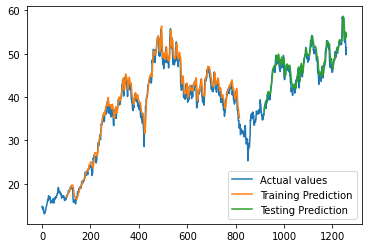

In [21]:

look_back=100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1),label = "Actual values")
plt.plot(trainPredictPlot,label = "Training Prediction")
plt.plot(testPredictPlot, label = "Testing Prediction")
plt.legend()
plt.show()
